In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
    
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def get_2d_simple_data(t, v1=.02, v2=.02):
    return np.random.multivariate_normal([np.cos(t), np.sin(t)], np.diagflat([v1, v2]), 100).astype(np.float32)
    
def two_pairplot(x12):
    df_x1 = pd.DataFrame(x12[0], columns=[r"${\bf x}^1$", r"${\bf x}^2$"]); df_x1["class"] = 'y=A'
    df_x2 = pd.DataFrame(x12[1], columns=[r"${\bf x}^1$", r"${\bf x}^2$"]); df_x2["class"] = 'y=B'
    df = pd.concat([df_x1, df_x2])
    sns.pairplot(df, hue="class");
    plt.show()


def plot_softmax2(cl=0, N=25):
    X = np.linspace(-1, 1, N)
    Y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(X, Y)
    XY = np.concatenate([X.reshape(N,N,1), Y.reshape(N,N,1)], axis=2)
    ### tensorflow
    XY_tf = tf.constant(XY) # softmaxはnumpy.arrayではだめっぽい
    Ey = tf.keras.activations.softmax(XY_tf) # これがsoftmax関数の実装
    ###
    contours = plt.contourf(X, Y, Ey[:,:,cl], 20)
    plt.xlabel(r"${\bf z}^0$", fontsize=20); plt.ylabel(r"${\bf z}^1$", fontsize=20)
    plt.title(r"Density of $[\langle {\bf y} \rangle = {\bf \sigma}_{softmax}({\bf z})]^%d$"%cl); plt.colorbar(); plt.show()

def plot_softmax3(cl=0, N=25):
    fig = plt.figure(); ax = fig.gca(projection='3d')
    # Make data.
    X = np.linspace(0, 5, N); Y = np.linspace(0, 5, N)
    X, Y = np.meshgrid(X, Y); Z = 5 - np.abs(Y) - np.abs(X)
    XYZ = np.concatenate([X.reshape(N,N,1), Y.reshape(N,N,1), Z.reshape(N,N,1)], axis=2)
    ### tensorflow
    XYZ_tf = tf.constant(XYZ) # softmaxはnumpy.arrayではだめっぽい
    Ey = tf.keras.activations.softmax(XYZ_tf)
    ###
    # Plot the surface.
    surf = ax.plot_surface(X*(Z>0), Y*(Z>0), Z*(Z>0), facecolors=plt.cm.coolwarm(Ey[:,:,cl]), shade=False)
    # Customize the z axis.
    ax.set_zlim(0, 5); ax.set_ylim([5, 0])
    ax.set_xlabel(r"${\bf z}^0$"); ax.set_ylabel(r"${\bf z}^1$"); ax.set_zlabel(r"${\bf z}^2$")
    ax.set_title(r"Density of $[\langle {\bf y} \rangle = {\bf \sigma}_{softmax}({\bf z})]^%d$"%cl)
    # Add a color bar which maps values to colors.
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm); sm.set_array(Ey[:,:,cl])
    fig.colorbar(sm, pad=.2); plt.show()

/Users/akinoritanaka/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


## 3-2. ニューラルネットと誤差関数
ニューラルネットワークを構成する基本要素を説明した後、深層ニューラルネットを導入します。

### 特徴量
入力ベクトル ${\bf x}$ が与えられたときの何らかの変数 $y$ についての条件付き確率 $q_\theta(y|{\bf x})$ を構成するのですが、また具体例を見てみましょう。例えば2次元データとラベル $\{ ({\bf x}_n, y_n  )\}$ で以下のようなデータがあったとします：

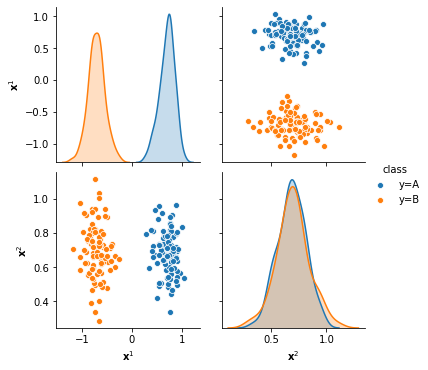

In [2]:
x_A = get_2d_simple_data(t=np.pi/4); x_B = get_2d_simple_data(t=np.pi/4+np.pi/2)
two_pairplot([x_A, x_B])

この二次元データは ${\bf x}$ の 第一座標 ${\bf x}^1$ でみると、クラスAとクラスBが分かれているけれど、第二座標 ${\bf x}^2$ でデータを見ると、両者の違いが無いように見えます。例えば、このような場合は ${\bf x}$ に適当な線形変換 $l$ をかけた

$$
{\bf z} = l({\bf x}) = W {\bf x} + {\bf b}
$$

を考えると、どちらの座標でも統計量が区別されるのがわかります。線形変換は深層学習ライブラリで簡単に実装できます。

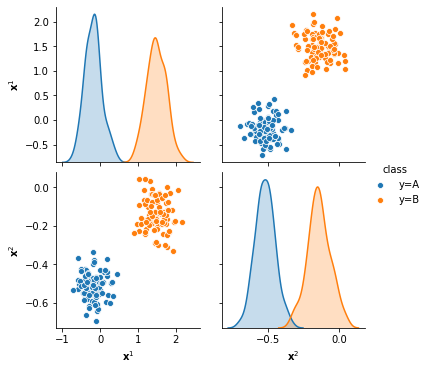

In [3]:
l = tf.keras.layers.Dense(2, input_shape=(2,)) # これが線形変換
z_A = l(x_A); z_B = l(x_B)
two_pairplot([z_A, z_B])


#### 一般の特徴量
より一般に、非線形変換 $f$ で

$$
{\bf z} = f({\bf x})
$$

が分類などのタスクをより処理しやすくする、データの背後にある何らかの特徴を抽出した量になっているとき、これを**特徴量(feature)**と言います。以下ではニューラルネットワークにおける特徴量の設計が、何らかの確率モデルについての**期待値**を層状に重ねたものと解釈できることを説明します。



### 2値ユニット
2値分類とは入力$x$を2値のラベルに分類する問題です。ここでは慣習に従い1ビット $\{ 0, 1\}$ への分類とします。また、入力は簡単のため1成分の実数としましょう

$$
y \in \{0, 1\},
\quad
x \in \mathbb{R}
$$

このような状況で条件付き確率$q_\theta(y|x)$を構成するにあたって、統計力学の考えを使いましょう。
統計力学の教えるところによると、自由度：$y$、エネルギー$E(y)$の系が温度 $T$ の環境下で定常状態に落ち着けば、$y$ の実現確率は

$$
q_E(y)=
\frac{e^{- \frac{E(y)}{k_B T}}}{Z}
$$

になるのでした。あとはエネルギーを考えれば良さそうです。
まずは外部から力 $z$ がかかっている状況を考えます。このとき$y$が実数であれば、これを変化分と考えて、仕事は$z y$と考えるのが自然でしょう。いま$y$は2値ですが、スピン変数とみなせば$z$は外部磁場と考えれば同じことです。注がれた仕事がエネルギーになるので

$$
E(y) = -z y
$$

でしょう。ここでどのような**力** $z$ を考えるかが丁度どのような**特徴量** を考えるかに対応します。$F(x)$として一番単純な線形変換による特徴量

$$
z = w x + b
$$

を取ることにしてみます。ここで$w, b$のスケールを適当に合わせれば$k_B T$はこれらの値に吸収できるので

$$
q_E(y)=
q_{w, b} (y|x)=
\frac{e^{(w x + b)y}}{Z}
$$

となります。$Z$ は $y=0,1$ についての足し算が1になるようにすれば良いので

$$
Z=
\sum_{y=0, 1}
e^{(w x + b)y}=
1 + e^{wx +b}
$$

であることがわかります。
>$Z$は統計力学で分配関数と呼ばれる量です。

従って

$$
q_{w, b} (y|x)=
\frac{e^{(w x + b)y}}{1 + e^{wx +b}}
$$

ということになりました。
これは非常にシンプルな確率モデルです。$y=0,1$である確率はそれぞれ

$$
\left. \begin{array}{ll}
&q_{w, b} (y=1|x)=
\frac{e^{w x + b}}{1 + e^{wx +b}}=
\frac{1}{e^{-(w x + b)} + 1}
:=
\sigma(wx + b)
\\
&q_{w, b} (y=0|x)=
1- q_{w, b} (y=1|x)=
1 - \sigma(wx + b)
\end{array} \right.
$$

と書くことができます。関数$\sigma$には名前がついており、(ロジスティック)シグモイド関数と呼ばれます。

#### 期待値 $\langle y \rangle$ とsigmoid関数
特に$y$の期待値

$$
\left. \begin{array}{ll}
\langle y \rangle_{q_{w, b}(\cdot|x)}
&=
1 \cdot q_{w, b} (y=1|x) + 0 \cdot q_{w, b} (y=0|x)
\\
&= 
\sigma(wx + b) = \sigma(z)
\end{array} \right.
$$

がシグモイド関数だけで書けているのが、後々のポイントとなります。$z$ が与えられたときのsigmoid関数はtensorflowでは以下のように書けます：


In [4]:
z = tf.constant([1.0])
tf.keras.activations.sigmoid(z)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.7310586], dtype=float32)>

このままだと出力が`tf.Tensor`というオブジェクトになっていますが、matplotlibへの入力としてそのまま使えるように調整してあるようです。例えば$z$ を-10から10まで100分割してsigmoid関数のプロットを描くと以下のようになります：

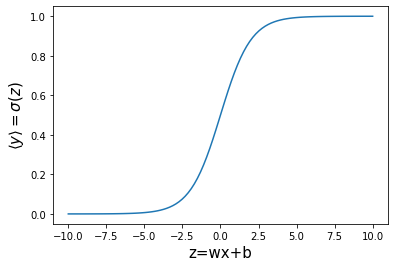

In [5]:
z = np.linspace(-10,10,100).astype(np.float32) # sigmoid関数はさらに、numpy入力でもエラーが出ないようです
plt.xlabel("z=wx+b", fontsize=15); plt.ylabel(r"$\langle y \rangle = \sigma(z)$", fontsize=15)
plt.plot(z, tf.keras.activations.sigmoid(z)); plt.show()

#### 経験誤差とsigmoidクロスエントロピー
この場合の<span style="color: red; ">汎化誤差</span>の近似、<span style="color: blue; ">経験誤差</span>${\color{blue}
{- \langle \log q_\theta(y|x) \rangle_{\hat{p}_N}}}$はどうなるか見てみますと、

$$
 \left. \begin{array}{ll} -\langle \log q_{w, b}(y|x) \rangle_{\hat{p}_N}
&= - \frac{1}{N} \sum_{n=1}^N \log q_{w, b} (y_n | x_n)
\\
&= - \frac{1}{N} \Big(
 \sum_{y_n=1} \log q_{w, b} (y_n=1 | x_n)
 +
  \sum_{y_n=0} \log q_{w, b} (y_n=0 | x_n)
 \Big)
\\
&= - \frac{1}{N} \Big(
 \sum_{y_n=1} \log \underbrace{ \sigma (wx_n+b) }_{\langle y \rangle_{q_{w, b}(\cdot|x_n)}}
 +
  \sum_{y_n=0} \log \{ 1 - \underbrace{ \sigma (wx_n+b)}_{\langle y \rangle_{q_{w, b}(\cdot|x_n)}} \}
 \Big)
 \\
&= \frac{1}{N} 
\sum_{n=1}^N
\underbrace{-
\Big(
y_n \log \langle y \rangle_{q_{w, b}(\cdot|x_n)}
 +
(1-y_n) \log \{ 1 - \langle y \rangle_{q_{w, b}(\cdot|x_n)} \}
 \Big)
 }_{=: L_\text{sigmoid} \Big( \langle y \rangle_{q_{w, b}(\cdot|x_n)} ,\ y_n \Big)}
\\
&=
\frac{1}{N} 
\sum_{n=1}^N
 L_\text{sigmoid} \Big( \langle y \rangle_{q_{w, b}(\cdot|x_n)} ,\ y_n \Big)
\end{array} \right.
$$

と、シグモイドクロスエントロピーと呼ばれる関数

$$
L_\text{sigmoid} (\langle y \rangle, y)
:=- \Big(y \log \langle y \rangle + (1-y) \log (1- \langle y \rangle) \Big)
$$

のサンプル平均として書くことができます。tensorflowでは`f = tf.nn.sigmoid_cross_entropy_with_logits`がこの誤差関数に対応しており、

$$
f (z, y)
:=- \Big(y \log \sigma(z) + (1-y) \log (1- \sigma(z)) \Big)
$$

の実装になっています：


In [6]:
logits = tf.constant([-10.0]) # z
labels = tf.constant([0.0]) # y
tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels) 

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.53989e-05], dtype=float32)>

$y=0, 1$の場合の $z$ に関するプロットは以下

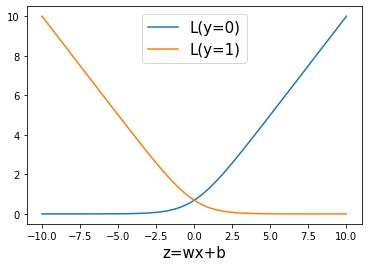

In [7]:
plt.xlabel("z=wx+b", fontsize=15)
for y in [0,1]:
    l = y*np.ones(100).astype(np.float32) # numpy入力でもエラーが出ないようです
    L = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=l) 
    plt.plot(z, L, label="L(y=%d)"%y)
plt.legend(fontsize=15); plt.show()

教師信号 $y$ について、
- $y=0$ のとき、$z<0$ の方が値が低く
- $y=1$ のとき、$z>0$ の値が低く

なっており、$\sigma(z)$の確率値と連動しているのがわかります。入力の次元が上がって${\bf x} = (x^1, x^2, \dots, x^L) \in \mathbb{R}^L$ となった場合も、エネルギーを

$$
E(y)= - ({\bf w} \cdot {\bf x} + b) y
$$

として同じことが繰り返せるため、

$$
\left. \begin{array}{ll}
&q_{{\bf w}, b}(y=1|{\bf x})=
\sigma ({\bf w} \cdot {\bf x} + b)=
\langle y \rangle_{q}
,
\\
&-\langle \log q_{{\bf w}, b}(y|{\bf x}) \rangle_{\hat{p}_N}=
\frac{1}{N} \sum_{n=1}^N
L_\text{sig} \Big(\langle y \rangle_{q} , y_n \Big)
\end{array} \right.
$$

がわかります。

### tanh ユニット
2値ユニットは出力の確率変数が 0 か 1 の場合のユニットでしたが、物理的には **downスピン** か **upスピン** かの $\pm 1$ を使いたくなる気もします。そのような場合に2値ユニットと同じことを繰り返すと $y = \pm 1$, $z = wx + b\in \mathbb{R}$ として

$$
q(y|x) = \frac{e^{- z y}}{Z} = \frac{e^{- z y}}{2\cosh(z)}
$$

となるのがわかります。従って

$$
\langle y \rangle_{q} = \frac{1}{2\cosh(z)} \underbrace{ \sum_{y=\pm1} y e^{- z y} }_{2 \sinh (z)} = \tanh (z)
$$

となるのがわかります。誤差関数も同様に計算できますが、tanhを最終出力にすることは稀なのでここでは割愛します。興味のある人はtanhユニットの誤差関数がどうあるべきか考えてみると良いかもしれません。


### 多値ユニット
2値ではないC値分類の場合でも、普通は

$$
{\bf y} = (y^1, y^2, \dots, y^C),
\quad
y^i \in \{ 0, 1\},
\quad
\exists^1 y^i =1, 
\text{otherwise 0}
$$

とします。
こちらの場合も、入力 ${\bf x}$ について最も単純なモデルは行列 $W$ とベクトル ${\bf b}$ を使った

$$
q_{W, {\bf b}} ({\bf y} | {\bf x})=
\frac{e^{{\bf y} \cdot (W {\bf x} + {\bf b})}}{Z}
$$

でしょう。この場合$({\bullet})^*$でベクトルの第$*$成分を表すとして、

$$
Z = e^{(W {\bf x} + {\bf b})^1} + e^{(W {\bf x} + {\bf b})^2} + \dots e^{(W {\bf x} + {\bf b})^C}  
$$

となりますが、ソフトマックス関数

$$
{\bf \sigma}_{softmax} ({\bf z})=
\frac{1}{e^{{z}^1} + e^{{z}^2} + \dots, e^{{z}^C} }
(e^{{z}^1}, e^{{z}^2}, \dots, e^{{z}^C})
$$

とすると

$$
q_{W, {\bf b}} \Big({\bf y} = (0, \dots,0, \underbrace{1}_{c}, 0, \dots, 0) \Big| {\bf x} \Big)=
\Big( {\bf \sigma} ( W {\bf x} + {\bf b} ) \Big)^c
$$

と書けることになります。

#### 期待値 $\langle {\bf y} \rangle$ とsoftmax関数
これはやはり

$$
\langle {\bf y} \rangle_{q_{W, {\bf b}}(\cdot|x)}=
{\bf \sigma}_{softmax}(W {\bf x} + {\bf b}) = {\bf \sigma}_{softmax}({\bf z})
$$

を意味します。softmax関数はsigmoid関数（2クラス）から多クラスへの自然な一般化になっています。tensorflowでは以下のように使えます：

In [8]:
z = tf.constant([[5.0, 0.0, 0.0]]) # [[]]となっているのに注意
tf.keras.activations.softmax(z)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9867033 , 0.00664835, 0.00664835]], dtype=float32)>

こんな風に ${\bf z}$ の成分で値が大きいほど割り振られる確率の値が大きくなります。プロットしてみると以下のような感じになります。（何次元でも使えますが、プロットの関係上2,3次元しかありません）

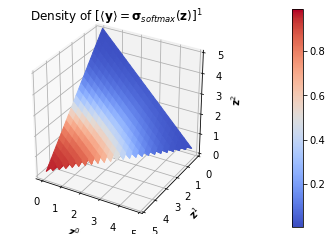

In [9]:
plot_softmax3(1)

#### 経験誤差とsoftmaxクロスエントロピー
また、負の対数尤度は

$$
\left. \begin{array}{ll}
& - \langle \log q_{W, {\bf b}} ({\bf y} | {\bf x}) \rangle_{\hat{p}_N}
\\
&= - \frac{1}{N}\sum_{n=1}^N
\log q_{W, {\bf b}} ({\bf y}_n | {\bf x}_n)
\\
&= - \frac{1}{N}
\Big(
\sum_{{\bf y}_n = [1]}
\underbrace{ \log q_{W, {\bf b}} ({\bf y}_n = [1]| {\bf x}_n) }_{
\Big( {\bf \sigma}_{softmax} ( W {\bf x} + {\bf b} ) \Big)^1} + \sum_{{\bf y}_n = [2]}
\underbrace{
\log q_{W, {\bf b}} ({\bf y}_n = [2]| {\bf x}_n)}_{
\Big( {\bf \sigma}_{softmax} ( W {\bf x} + {\bf b} ) \Big)^2
}+\dots\sum_{{\bf y}_n = [C]}
\underbrace{\log q_{W, {\bf b}} ({\bf y}_n = [C]| {\bf x}_n)}_{\Big( {\bf \sigma}_{softmax} ( W {\bf x} + {\bf b} ) \Big)^C}
\Big)
\\
&=
\frac{1}{N}
\sum_{n=1}^N
\Big(-
{\bf y}_n \cdot
{\bf \log}
{\bf \sigma}_{softmax} ( W {\bf x} + {\bf b} )
\Big)=
\frac{1}{N}
\sum_{n=1}^N
\Big(-
{\bf y}_n \cdot
{\bf \log}
\langle {\bf y} \rangle_{q_{W, {\bf b}}(\cdot|x_n)}
\Big)
\end{array} \right.
$$

ここで ${\bf \log} ({\bf X}) = (\log X^1, \log X^2, \dots, \log X^C)$ という意味で使いました。この最後の大かっこ中の関数をsoftmaxクロスエントロピーといいます：

$$
L_{softmax}(\langle {\bf y} \rangle, {\bf y})
:= - {\bf y} \cdot {\bf \log} \ \langle {\bf y}\rangle =- \sum_{i=1}^C y^i \log \langle y^i \rangle
$$

これは $C=2$ の場合、sigmoidクロスエントロピーなので確かに二値分類の自然な一般化になっています。tensorflowでは以下のように使えます：



In [10]:
logits = [[4.0, 2.0, 1.0], [0.0, 5.0, 1.0]] # z = Wx+b に対応
labels = [[1.0, 0.0, 0.0], [0.0, 0.8, 0.2]] # y に対応
tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits).numpy()

array([0.16984604, 0.82474494], dtype=float32)

出力値が2成分ベクトルになっていますが、これは $\frac{1}{N} \sum_{n=1}^N$ の平均を取る前の各成分の値を表しています。平均を取ったものは以下

In [11]:
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce(
  [[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
loss.numpy()

0.09458993

### 線形回帰ユニット
次に $y \in \mathbb{R}$ の場合ですが、初めに説明した多項式フィッティングなどを考える場合

$$
q_{w, b}(y|x)=
\frac{1}{\sqrt{2 \pi}} e^{- \frac{1}{2} ( y - ( wx + b  ) )^2 }
$$

を考えると$y$の期待値は

$$
\langle y \rangle_{q_{w,b}(\cdot | x)}=
wx + b
$$

であり、対数尤度からは最小二乗法の場合の目的関数を得ることができます：

$$ - \langle \log q_{w,b} (y | x) \rangle_{\hat{p}_N}=
\frac{1}{N}
\sum_{n=1}^N
\Big(
\frac{1}{2}  \Big( y_n - \langle y \rangle_{q_{w,b}(\cdot | x_n)} \Big)^2
+
\log \sqrt{2 \pi}
\Big)
$$

これは成分数が増えても同様に

$$
\left. \begin{array}{ll}
& q_{W, {\bf b}}({\bf y}|{\bf x}) =
\Big(\frac{1}{\sqrt{2 \pi}}\Big)^{\text{dim}({\bf y})}
 e^{- \frac{1}{2} ( {\bf y} - ( W{\bf x} + {\bf b}  ) )^2 },
 \quad
 \langle {\bf y} \rangle_{q_{W, {\bf b}}(\cdot|{\bf x})}=
 W{\bf x} + {\bf b}
\\
&- \langle \log q_{W,{\bf b}} ({\bf y} | {\bf x}) \rangle_{\hat{p}_N} =
\frac{1}{N}
\sum_{n=1}^N
\Big(
\frac{1}{2}  \Big( {\bf y}_n -  \langle {\bf y} \rangle_{q_{W, {\bf b}}(\cdot|{\bf x}_n)} \Big)^2
+
\text{dim}({\bf y})
\log \sqrt{2 \pi}
\Big)
\end{array} \right.
$$

となって自然に拡張できます。この経験誤差最小化は、**最小二乗法**になっています。この自乗誤差も実装されています：

In [12]:
mse = tf.keras.losses.MeanSquaredError()
loss = mse([0., 0., 1., 1.], [1., 1., 1., 0.])
loss.numpy()

0.75

### 正規化線形ユニット（Rectified Liner Unit, ReLU）
連続値出力を表現する他の方法にReLUと呼ばれるものがあります。
ReLUではまず、$M$ビットからなる2値ユニット$h^k \in \{ 0, 1 \}, k=1,2, \dots, M$を考え、

$$
\left. \begin{array}{ll}
&q_{w, b}(h^k=1 | x)=
\sigma (wx +b + 0.5 - k )
\\
&
q_{w, b} (y|x)=
\delta (y - \sum_{k=1}^M h^k)
\prod_{k=1}^M 
q_{w, b}(h^k | x)
\end{array} \right.
$$

とします。ここで $\delta(y)$ はディラックのデルタ関数です。
歴史的にはこのユニットはボルツマン機械において、2値ユニットの性能を上げるために重み共有によるアンサンブル近似として導入されましたが、以下の簡単化をすることで深層ニューラルネットに広く用いられるようになりました。

$y = \sum_{k=1}^M h^k$ なので、$M$ ビットのうち何個が発火($h=1$)しているかを数えるのが $y$ だということですが、$M$ はアンサンブルの個数なので大きな数を取りたいわけです。すると何個発火しているかを数えるのは面倒ですし、理論的に解析するのが難しくなってしまいます。
そこで思い切って、$y = \langle \sum_{k=1}^M h^k \rangle_{q_{w, b}}$ としてみます。すなわち

$$
\tilde{q}_{w, b} (y|x) =
\delta \Big(y - \langle \sum_{k=1}^M h^k \rangle_{q_{w, b}} \Big)
$$

とするのです。この期待値は

$$
\left. \begin{array}{ll}
\langle \sum_{k=1}^M h^k \rangle_{q_{w, b}} 
&=
\sum_{k=1}^M \langle h^k \rangle_{q_{w, b}(\cdot|x)} 
 \\
&= %%%%
\sum_{k=1}^M 
\Big(
1 \cdot \underbrace{ q_{w, b}(h^k = 1|x) }_{\sigma (wx + b +0.5 -k) } +
0 \cdot q_{w, b}(h^k = 0|x)
\Big)
 \\
&= %%%%
\sum_{k=1}^M 
\sigma (wx + b +0.5 -k) 
\end{array} \right.
$$

と、シグモイド関数を0.5ずつずらした値を足し上げる関数になります。これをプロットしてみると、以下のようになります：

In [13]:
def replicated_sigmoid_tf(z, M=10, out=0):
    for k in range(1, M+1):
        out += tf.keras.activations.sigmoid(z+.5-k)
    return out

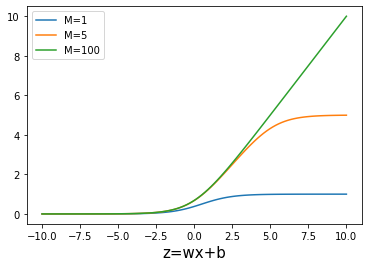

In [14]:
z = np.linspace(-10,10,100).astype(np.float32)
plt.xlabel("z=wx+b", fontsize=15)
for M in [1, 5, 100]:
    plt.plot(z, replicated_sigmoid_tf(z, M=M) , label="M={}".format(M))
plt.legend(); plt.show()

段々と何らかのきれいな関数に漸近しているのがわかります。 この関数の$M\to \infty$極限を$k$に関するRiemann積分で更に近似してみます

$$ \left. \begin{array}{ll}
\sum_{k} \sigma(X - {[k - 0.5]})
&=
\sum_{k} \sigma(X - {[k - 0.5]}) \Delta k
 \\
&\approx %%%%
\int_0^\infty \sigma(X- k) dk
 \\
&= %%%%
\int_0^\infty 
\frac{1}{e^{-X +k} + 1}
 dk
  \\
&= %%%%
\int_0^\infty 
\frac{e^{X - k} }{1 + e^{X - k}}
 dk
   \\
&= %%%%
\int_{k=\infty} ^{k=0} 
\frac{1}{1 + e^{X - k}}
 d(e^{X - k} )
    \\
&= %%%%
\int_{K=0} ^{K=e^X} 
\frac{1}{1 + K}
 dK
 \\
&= %%%%
\log (1+e^X)
=:
\sigma_{softplus}(X)
\end{array} \right. $$

これはsoftplus関数と呼ばれる非線形関数です。softplus関数が実際に元のsigmoid関数の重ね合わせをよく近似している様子を確かめてみます：

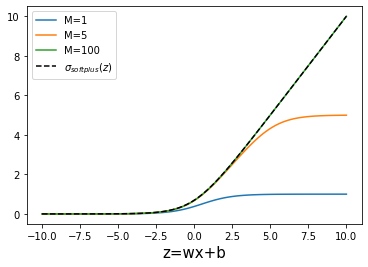

In [15]:
plt.xlabel("z=wx+b", fontsize=15)

for M in [1, 5, 100]:
    Ey = replicated_sigmoid_tf(z, M=M) 
    plt.plot(z, Ey, label="M={}".format(M))
plt.plot(z, tf.keras.activations.softplus(z), "--", color='black', label=r"$\sigma_{softplus}(z)$")
plt.legend(); plt.show()


softplus関数は更にスケール変換することで

$$ \left. \begin{array}{ll}
\lim_{\Lambda \to \infty}
\frac{1}{\Lambda}
\sigma_\text{sp}(\Lambda X)
=\max(0, X)
=: \sigma_\text{ReLU}(X)
\end{array} \right. $$

となることがわかります。深層学習におけるReLUとはここまで近似したものをいいます
>あるいは2値ユニットを考えずにはじめからmaxで書けているとします。実際多くの文献ではmaxで導入していますが、これをやられると「なぜmax?」と不思議に思うでしょう。
まぁ、ここでの導入も「なぜ？」と思うところは多々ありますが。。

$$ \left. \begin{array}{ll}
q_{w, b}(y|x)
=\delta \Big(y - \sigma_\text{ReLU}(wx+b) \Big)
\end{array} \right. $$

多成分になっても、やはり成分ごとにmaxし

$$ \left. \begin{array}{ll}
q_{W, {\bf b}}({\bf y}|{\bf x}) = \delta \Big({\bf y} - {\bf \sigma}_\text{ReLU}(W{\bf x}+{\bf b}) \Big)
\end{array} \right. $$

とします。やはり

$$ 
\langle {\bf y} \rangle_{q_{W, {\bf b}}(\cdot | {\bf x})}= {\bf \sigma}_\text{ReLU}(W{\bf x}+{\bf b})
$$

と書けます。

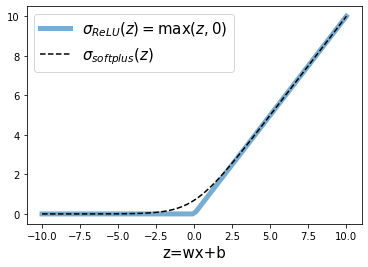

In [16]:
plt.xlabel("z=wx+b", fontsize=15)
plt.plot(z, tf.keras.activations.relu(z), linewidth=5, alpha=0.6, label=r"$\sigma_{ReLU}(z) = \max(z, 0)$")
plt.plot(z, tf.keras.activations.softplus(z), "--", color='black', label=r"$\sigma_{softplus}(z)$")
plt.legend(fontsize=15); plt.show()

### 深層ニューラルネット
ここまで、どのユニットでも何らかの(非線形)関数 ${\sigma}_{\spadesuit}$ を用いて

$$ \left. \begin{array}{ll}
\langle {\bf y} \rangle_{q_{W, {\bf b}}(\cdot | {\bf x})} =
{\bf \sigma}_{\spadesuit} (W {\bf x} + {\bf b})
\end{array} \right. $$

と書けるものばかりでした。これを多層化、深層化するとは$\langle {\bf y} \rangle$を新たな入力(あるいは**特徴量**)と考え、逐次的な構造

$$ 
{\color{blue} {\bf x}}
\to
{\color{green}{\langle {\bf h}_1 \rangle_{q_{W_1}(\cdot | {\color{blue}{\bf x}})}}}
\to
{\color{magenta}{\langle {\bf h}_2 \rangle_{q_{W_2}(\cdot | {\color{green}{\langle {\bf h}_1 \rangle}})}}}
\to
\cdots
\to
{\color{red}{\langle {\bf h}_L = {\bf y} \rangle_{q_{W_L}({\bf y} | {\color{cyan}{\langle {\bf h}_{L-1} \rangle} })}}}
$$

というモデル $q_\theta({\bf y}|{\bf x}) = q_{W_L}({\bf y} | \langle {\bf h}_{L-1} \rangle)
$ を考えることに対応します。ここで $\theta = \{W_1, W_2, \dots, W_L\}$ です。
>${\bf b}$はそろそろ面倒なので略しますが、ずっと存在していると思ってください。あるいは
$$ \left. \begin{array}{ll}
{\bf x} \oplus 1 := {\bf X},
\quad
(W\oplus {\bf b}) {\bf X}
:=
\tilde{W} {\bf X}
\end{array} \right. $$
と$W$の一部だと考えることもできます。

これを$L$層ニューラルネットと呼びます。これは

$$ \left. \begin{array}{ll}
{\color{red}{\langle {\bf y} \rangle}_{q_\theta(\cdot | {\color{blue}{\bf x}})}}=
{\color{red}{{\bf \sigma}_{\spadesuit}
\Bigg(
W_L {\color{cyan}{{\bf \sigma}_{\heartsuit}
    \Big(
    {\color{black}{
    \dots
        {\color{magenta}{
        {\bf \sigma}_{\clubsuit} \big(
        W_2 
            {\color{green}{
            {\bf \sigma}_{\diamondsuit} (
            W_1 
                {\color{blue}
                {\bf x}
                }
            )
            }}
        \big)
        }}
    }}
    \Big)
     }}
\Bigg)
}}
\end{array} \right. $$
のような、「線形変換」と「非線形変換」の繰り返し構造になっているのがわかります。多くの文献ではこの表現から始めますが、背後にはここまで説明してきたような逐次的に期待値を取る構造があるとわかります。その文脈では深層ニューラルネットにおける「非線形変換」は何らかの確率モデルで期待値を取る操作に対応することがわかります。


#### 経験誤差
深層ニューラルネット $q_\theta({\bf y} | {\bf x})$ の負の対数尤度＝経験誤差は結局最終層の $q_{W_L}({\bf y} | \langle {\bf h}_{L-1} \rangle)$ についての負の対数尤度となるので、最終層から誘導される誤差関数 $L_\spadesuit$ をもちいて

$$ \left. \begin{array}{ll} - \langle \log q_\theta ({\bf x} | {\bf y} ) \rangle_{\hat{p}_N}=
\frac{1}{N}
\sum_{n=1}^N L_{\spadesuit} \Big(
{\color{red}{\langle {\bf y} \rangle}_{q_\theta(\cdot | {\color{blue}{\bf x_n}})}}
,
{\bf y}_n
\Big)
\end{array} \right. $$

となります。負の対数尤度がわかったので、あとは1節で説明したように、これを最小化するようなパラメータ $\theta = \{W_1, \dots, W_L \}$ を見つければよいわけです。その方法を次に説明します。

1節の終わりでもコメントしましたが、このような深層ニューラルネットは一般に巨大な数のパラメータを持つため、汎化は期待できない気がするところを(すくなくともテストデータなどを用いた経験的なチェックで)汎化する例が数多く知られています。ただし汎化させるためには闇雲に構成するのではなく、様々なテクニックが必要です。

#### 実装1
TensorFlow実装の方法は数種類ありますが、簡単なのは以下のように`tf.keras.models.Sequential`を用いた構成です：

In [17]:
H=10
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(H, input_shape=(4,), activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

x = np.random.rand(2, 4).astype(np.float32)
model(x)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.68773806, 0.14139709, 0.17086484],
       [0.5748978 , 0.24180563, 0.18329652]], dtype=float32)>

#### 実装2
`tf.keras.models.Sequential`は楽ちんですが、複雑なことはできません。慣れてきて複雑なことをしたくなったら、`tf.keras.Model`を継承してモデルのクラスを定義して使うのが便利です。多くの研究論文の実装ではこちらが使われます。

In [18]:
class MyModel(tf.keras.Model):
    def __init__(self, H=10):
        super(MyModel, self).__init__()
        self.l1 = tf.keras.layers.Dense(units=H)
        self.l2 = tf.keras.layers.Dense(units=3)
 
    def call(self, x):
        h = tf.keras.activations.relu(self.l1(x))
        h = tf.keras.activations.softmax(self.l2(h))
        return h
    
model = MyModel()
x = np.random.rand(2, 4).astype(np.float32)
model(x)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.10955901, 0.7718035 , 0.11863752],
       [0.16473636, 0.70049   , 0.13477369]], dtype=float32)>

`tf.keras.layers`のクラスを内部に含んでいる事がわかりますが、このLayersクラスも`tf.keras.layers.Layer`を継承して自分でカスタマイズしたものを使うこともできます。詳しくはhttps://www.tensorflow.org/guide/keras/custom_layers_and_models を参照してください。

### 図で表現するルール
このように深層ニューラルネットは数学的な素材としては単純なものです。しかしその真価は
* **手では計算が追いきれないほど複雑なネットワークを構成**する

ところにあります。すべての計算を追うことは不可能ですが、「どういう処理がなされているのか」を視覚的に表現したい場合があります。よく使われるのは、ベクトルの各成分をノードとして、線形変換をエッジとしてグラフの形で表現する記法ですが、今回は以下で説明する**線でベクトルを表現する方法**を採用することにします。


#### ベクトルの表現
二次元ベクトルや三次元ベクトルであれば、実際のベクトル ${\bf x}$ や対応する点を上の図のように描けるので良いのですが、深層学習などで用いられるベクトルは数十次元〜数万次元に渡ります。その様になったときのためにベクトルを絵で表現するのに、濃淡の線が並行したものとして表現してみます。例えば以下は適当な5次元ベクトルを図示したものです：

![alt](vect.jpg)

線の濃淡は場合によってはつけずに、全て同じ濃さで描く場合もありますが悪しからず。

#### 線形変換の表現
この記法で線形変換 ${\color{blue}{\bf z}} ={\color{red}{W}}{\bf x} + {\color{red}{\bf b}}$
を以下のように表現します：

![alt](lin.jpg)

ベクトルは異なるベクトルであることを強調したい場合は色を変えて描きますが、**線形変換は必ず赤色で描くことにします**。こうしておくと複雑なネットワークを図示したとき、どこに調整できるパラメータがあるのか分かりやすいからです。

#### 非線形変換の表現
非線形変換は角の丸い囲み枠で囲んで表現します。

![alt](sigma.jpg)

非線形変換は特筆しない限りベクトルの成分毎にかかります：

$$
\sigma({\bf z}) = \left( \begin{array}{ll}
\sigma(z_1) \\
\sigma(z_2) \\
\\
\vdots
\\
\sigma(z_\clubsuit)
\end{array} \right)
$$

ここまでの表現で例えば

![alt](nn.jpg)

と描くと、処理を数式で実際に書くよりも瞬時にネットワーク構造が把握できて良いでしょう。

#### よく使われる図との比較

ここでの表記法はあまり使われないのですが、この節以後に登場する処理を最もわかりやすく表そうと考えた結果、このような記法を今回は採用することにしました。よく使われる図と並べて描いたのが以下です：

![alt](various_lin.jpg)

右側ではベクトルの成分はノード（○）で表され、線形変換は今回と同じ用にノードをつなぐ線（または矢印）として表現されます。また、非線形変換の関数は絵に描かない場合が多い気がしますが、描かれる場合は対応するノードを単なる○ではなく、左図にあるような適応される非線形関数の絵を描いたノードを用いる場合がありますが、著者が好きなように描いている場合もあります。